1.0


<Figure size 640x480 with 0 Axes>

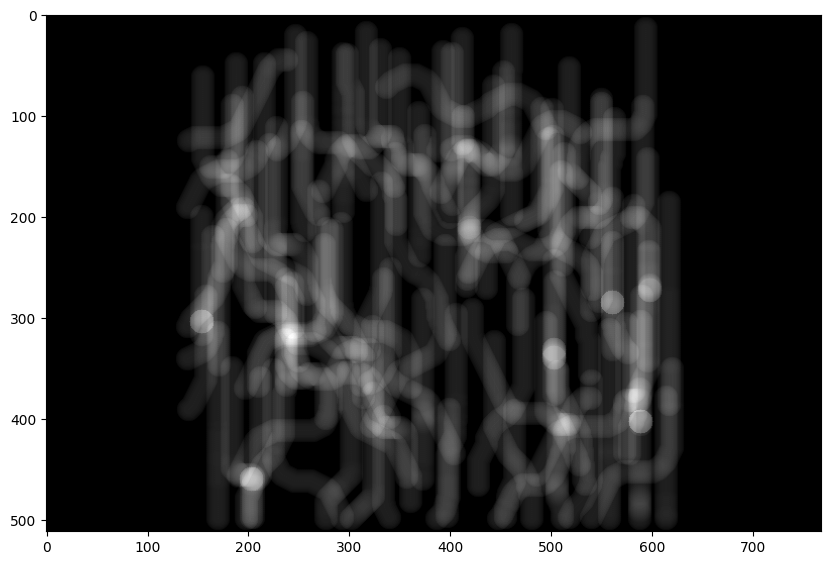

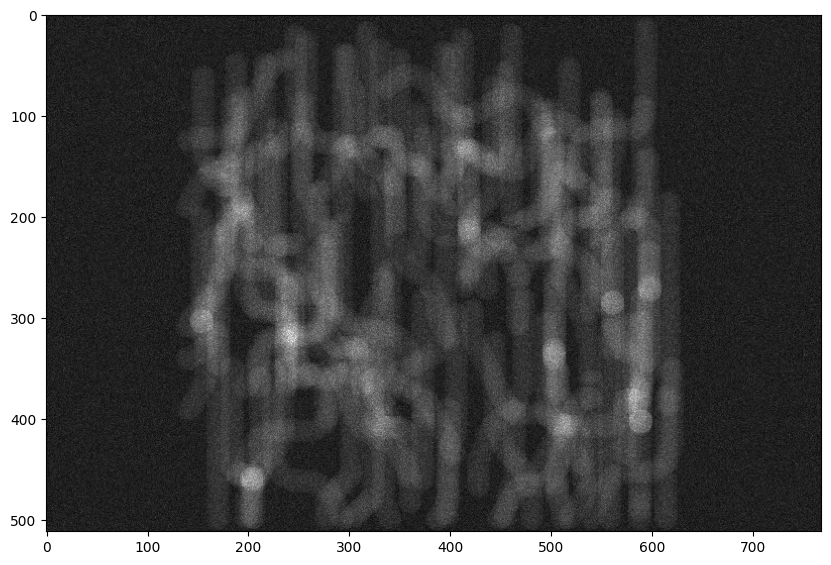

In [4]:
import astra
import numpy as np
import pylab
import matplotlib.pyplot as plt


volume = np.load('volume.npy')

print(volume.max())

if volume.shape != (512, 512, 512):
    raise ValueError("Volume dimensions are not 512x512x512.")

vol_geom = astra.create_vol_geom(512, 512, 512)

angles = np.linspace(0, np.pi, 180, False)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 512, 768, angles)


proj_id_original, proj_data_original = astra.create_sino3d_gpu(volume, proj_geom, vol_geom)

####################################

# Poisson
i0 = 100 # how many photos are being transmitted 
gamma = 0.01 # attenuation coefficient, higher means more attenuating

virtual_photon_count = i0*np.exp(-gamma*proj_data_original)

# print(np.exp(-gamma*proj_data_original)[proj_data_original>0].mean())
noisy_virtual_photon_counts = np.random.poisson(virtual_photon_count)
proj_data_noisy = -np.log(noisy_virtual_photon_counts/i0)/gamma

####################################

proj_id_noisy = astra.data3d.create('-sino', proj_geom, proj_data_noisy)

pylab.gray()
pylab.figure(figsize=(10, 8))
pylab.imshow(proj_data_original[:, int(proj_data_original.shape[1] / 2), :])

pylab.gray()
pylab.figure(figsize=(10, 8))
pylab.imshow(proj_data_noisy[:, int(proj_data_noisy.shape[1] / 2), :])

###############################

# # For reconstructing one slice only 
# vg = astra.create_vol_geom(512,512)
# pg = astra.create_proj_geom('parallel', 1, 768, angles)
# pid = astra.create_projector('cuda',pg,vg)
# w = astra.OpTomo(pid)

# rec = w.reconstruct('SIRT_CUDA',proj_data_noisy[256], 100)
# rec2 = w.reconstruct('SIRT_CUDA',proj_data_original[256], 100)

# pylab.figure(figsize=(10, 8))
# pylab.gray()
# pylab.imshow(rec,vmin=0,vmax=1)
# pylab.figure(figsize=(10, 8))
# pylab.imshow(rec2, vmin=0, vmax=1)

###############################

rec_id_original = astra.data3d.create('-vol', vol_geom)
cfg_original = astra.astra_dict('SIRT3D_CUDA')
cfg_original['ReconstructionDataId'] = rec_id_original
cfg_original['ProjectionDataId'] = proj_id_original
alg_id_original = astra.algorithm.create(cfg_original)
astra.algorithm.run(alg_id_original, 150)
rec_original = astra.data3d.get(rec_id_original)

rec_id_noisy = astra.data3d.create('-vol', vol_geom)
cfg_noisy = astra.astra_dict('SIRT3D_CUDA')
cfg_noisy['ReconstructionDataId'] = rec_id_noisy
cfg_noisy['ProjectionDataId'] = proj_id_noisy
alg_id_noisy = astra.algorithm.create(cfg_noisy)
astra.algorithm.run(alg_id_noisy, 150)
rec_noisy = astra.data3d.get(rec_id_noisy)

astra.algorithm.delete(alg_id_original)
astra.algorithm.delete(alg_id_noisy)
astra.data3d.delete(rec_id_original)
astra.data3d.delete(rec_id_noisy)
astra.data3d.delete(proj_id_original)
astra.data3d.delete(proj_id_noisy)

# Save the reconstructed volumes as .npy files
np.save('reconstructed_original.npy', rec_original)
np.save('reconstructed_noisy.npy', rec_noisy)


# # Calculate the difference for the visualized slice
# difference_slice = proj_data_noisy[:, int(proj_data_noisy.shape[1] / 2), :] - proj_data_original[:, int(proj_data_original.shape[1] / 2), :]

# # Visualize the difference
# pylab.figure(figsize=(10, 8))
# pylab.gray()
# pylab.imshow(difference_slice)
# pylab.title('Difference bet Original and Noisy Projection')

In [5]:
def mse(imageA, imageB):
    if imageA.ndim != 3 or imageB.ndim != 3:
        raise ValueError("Both images must be 3D arrays.")
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) # summation of square diff
    err /= float(imageA.size)
    return err

def rmse(imageA, imageB):
    return np.sqrt(mse(imageA, imageB))


rmse_original = rmse(volume, rec_original)
rmse_noisy = rmse(volume, rec_noisy)

print("RMSE Original Reconstruction:", rmse_original)
print("RMSE Noisy Reconstruction:", rmse_noisy)

RMSE Original Reconstruction: 0.05773491406842965
RMSE Noisy Reconstruction: 0.19861745878385637


In [6]:
import numpy as np
import nibabel as nib

# Load the numpy array
rec_original = np.load('reconstructed_original.npy')
rec_noisy = np.load('reconstructed_noisy.npy')

# Convert to NIfTI and save
nib.save(nib.Nifti1Image(rec_original, np.eye(4)), 'reconstructed_original.nii')
nib.save(nib.Nifti1Image(rec_noisy, np.eye(4)), 'reconstructed_noisy.nii')

# Then in 3d slicer, adjust 'scalar opacity map' to see actual fibers
